In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import median_abs_deviation


In [2]:
def preprocess(df):
    listIntToBool = ['AU7', 'AU20', 'looking_away']
    for col in listIntToBool:
        df[col] = df[col].astype('bool')
        
    listBB = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
    listLandmarks = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
    listTime = ['Timestamp']
    
    listAUDiff = ['AU1_diff','AU2_diff','AU4_diff','AU5_diff','AU6_diff','AU7_diff','AU9_diff','AU10_diff','AU11_diff','AU12_diff',
                'AU14_diff','AU15_diff','AU17_diff','AU20_diff','AU23_diff','AU24_diff','AU25_diff','AU26_diff','AU28_diff','AU43_diff']
    listEmoDiff = ['disgust_diff','fear_diff','happiness_diff', 'anger_diff', 'sadness_diff','surprise_diff','neutral_diff','emotion_mirroring_diff']
    
    listEyes = ['eyeWidth', 'eyeHeight', 'mean_EAR', 'mean_pupil_ratio']
    
    listAU = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11',
              'AU12','AU14','AU15','AU17','AU20','AU23','AU24','AU25','AU26','AU28','AU43']
    
    listFaceDirection = ['Pitch', 'Yaw', 'Roll']
    
    featureTest = ['AU5', 'AU10', 'AU15', 'AU26', 'AU28', 'looking_away', 'AU1_diff', 'AU2_diff', 'AU4_diff', 'AU5_diff', 'AU6_diff', 'AU7_diff', 'AU9_diff', 'AU10_diff', 
                   'AU11_diff', 'AU12_diff', 'AU14_diff', 'AU15_diff', 'AU17_diff', 'AU20_diff', 'AU23_diff', 'AU24_diff', 'AU25_diff', 'AU26_diff', 'AU28_diff', 
                   'AU43_diff', 'anger_diff', 'disgust_diff', 'fear_diff', 'happiness_diff', 'surprise_diff', 'neutral_diff', 'emotion_mirroring_diff']
    ##      + listEmoDiff 
     ## 'pupil_deviation'
    
    totalcolumns = listBB + listLandmarks + listTime  + listEyes + featureTest# + listFaceDirection
        
    df = df.drop(columns = totalcolumns)
    df = df.drop(columns=['pupil_direction', 'Person'])
    df = df[df['Label'] != 'x']
    df = df[df['Label'] != 'skip']
    df['Label'] = df['Label'].replace({'n': 0, 'no': 0, 'y': 1, 'yes': 1})
    return df



def calculate_global_statistics(df, columns):
    """
    Calculate global statistics for the entire DataFrame.
    """
    global_stats = {}
    for col in columns:
        global_stats[col] = {
            'mean': df[col].mean(),
            'std': df[col].std()
        }
    return global_stats


# def generate_chunk_summary(chunk, fullList=[], meanSDList=[]):
#     chunk_df = pd.DataFrame(chunk)
#     chunk_summary = chunk_df.mean().to_dict()  # calculate mean for all columns
#     for col in fullList:  # calculate quartiles and standard deviation for columns in fullList
#         chunk_summary.update({
#             f'{col}_mean': chunk_df[col].mean(),
#             f'{col}_Q1': chunk_df[col].quantile(0.25),
#             f'{col}_Q2': chunk_df[col].median(),
#             f'{col}_Q3': chunk_df[col].quantile(0.75),
#             f'{col}_SD': chunk_df[col].std(),
#             f'{col}_MAD': median_abs_deviation(chunk_df[col])
#         })
#     for col in meanSDList:  # calculate quartiles and standard deviation for columns in fullList
#         chunk_summary.update({
#             f'{col}_mean': chunk_df[col].mean(),
#             f'{col}_SD': chunk_df[col].std(),
#         })    
#     chunk_summary['Label'] = chunk_df['Label'].values[-1]
#     return chunk_summary

def generate_chunk_summary(chunk, global_stats, fullList=[]):
    """
    Modified function to include statistics of each chunk relative to global statistics.
    """
    chunk_df = pd.DataFrame(chunk)
    chunk_summary = {}
    
    for col in fullList:
        # Calculate z-scores for the chunk
        z_scores = (chunk_df[col] - global_stats[col]['mean']) / global_stats[col]['std']
        # Calculate percentiles for the chunk
        percentiles = [(val - global_stats[col]['mean']) / (global_stats[col]['std'] + 1e-8) for val in chunk_df[col].quantile([0.25, 0.5, 0.75])]
        
        # Append to chunk_summary
        chunk_summary.update({
            f'{col}_Z_scores': z_scores.tolist(),
            f'{col}_percentiles': percentiles,
        })
        
    chunk_summary['Label'] = chunk_df['Label'].values[-1]
    return chunk_summary


def create_chunks(df, chunk_size):
    fullList = ['EAR']  # You can include other columns here
    df_new = pd.DataFrame()
    current_chunk = []
    start_of_probe = -1
    summaries = []
    
    # Calculate global statistics before chunking
    global_stats = calculate_global_statistics(df, fullList)

    for _, row in df.iterrows():
        if start_of_probe < 0 or (row['Frame'] - start_of_probe) >= 500:
            # Finalize the current chunk, if there is one
            if current_chunk:
                chunk_summary = generate_chunk_summary(current_chunk, global_stats, fullList)
                summaries.append(chunk_summary)
            
            # Start a new probe and a new chunk
            start_of_probe = row['Frame']
            current_chunk = [row]
        elif len(current_chunk) == chunk_size:
            # We have a complete chunk, so finalize it
            chunk_summary = generate_chunk_summary(current_chunk, global_stats, fullList)
            summaries.append(chunk_summary)
            current_chunk = [row]
        else:
            # Add the current row to the current chunk
            current_chunk.append(row)

    # Finalize the last chunk, if there is one
    if current_chunk:
        chunk_summary = generate_chunk_summary(current_chunk, global_stats, fullList)
        summaries.append(chunk_summary)
    
    df_new = pd.DataFrame(summaries)

    return df_new

def preprocess_and_chunk(filename, chunk_size, diff_columns=[]):
    df = pd.read_csv(filename)
    for column in diff_columns:
        df[f'{column}_difference'] = df[column].diff()
    df['head_movement'] = df[['Pitch', 'Yaw', 'Roll']].diff().abs().sum(axis=1)
    df['Yaw_normalized'] = (df['Yaw'] + 90) / 180
    df['combined_gaze'] = (df['Yaw_normalized'] + df['pupil_ratio']) / 2
    df = df.drop(columns='Yaw_normalized')
    mean_value = df['EAR'].iloc[:1000].mean()
    combined_gaze = df['combined_gaze'].iloc[:1000].mean()
    df['calibrated_EAR'] = mean_value
    df['calibrated_combined_gaze'] = combined_gaze
    df['gaze_deviation'] = abs(df['combined_gaze'] - df['calibrated_combined_gaze'])
    df['pupil_deviation'] = abs(df['mean_pupil_ratio'] - df['pupil_ratio'])
    df['EAR_deviation'] = abs(df['EAR'] - df['calibrated_EAR'])
    df = preprocess(df)
    df_chunks = create_chunks(df, chunk_size)
    df_chunks = df_chunks.drop(columns=['calibrated_EAR', 'calibrated_combined_gaze'])
    return df_chunks

def checkForFullYes(filename):
    df = pd.read_csv(filename)
    counts = df['Label'].value_counts()
    no_count = counts.get('no', 0)
    n_count = counts.get('n', 0)
    finalcount = no_count + n_count
    #print(filename, finalcount)
    return finalcount

In [3]:
kalman = False
if kalman == True:
    kalman = '_kalman'
else: kalman = ''
print(kalman)
number = 250
filenames = [f"finaldata_{number}{kalman}/{i}.csv" for i in range(1, 39)]  ## ["1.csv", "2.csv", ..., "38.csv"]

test_indices = [5, 8, 15, 17, 23, 32, 37]  ## generate test set based on index name

train_filenames = [f for i, f in enumerate(filenames, start=1) if i not in test_indices]
test_filenames = [f for i, f in enumerate(filenames, start=1) if i in test_indices]

dataframes_train = []
dataframes_test = []

chunkBool = True
chunk_size = 25

if chunkBool:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue        
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_train.append(chunked_df)
    
    for filename in test_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue          
        chunked_df = preprocess_and_chunk(filename, chunk_size)
        dataframes_test.append(chunked_df)
else:
    for filename in train_filenames:
        finalcount = checkForFullYes(filename)
        if finalcount == 0:
            continue  
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_train.append(preprocessed_df)

    for filename in test_filenames:
        df = pd.read_csv(filename)
        preprocessed_df = preprocess(df)
        dataframes_test.append(preprocessed_df)
    

train_combined_df = pd.concat(dataframes_train, ignore_index=True)
X_train = train_combined_df.drop(columns=['Label', 'Frame'])
y_train = train_combined_df['Label']

test_combined_df = pd.concat(dataframes_test, ignore_index=True)
X_test = test_combined_df.drop(columns=['Label', 'Frame'])
y_test = test_combined_df['Label']


In [4]:
y_test.value_counts()

1    25340
0     4791
Name: Label, dtype: int64

In [5]:
smote = SMOTE(random_state=42)

In [6]:
print(len(y_train))
print(y_train.value_counts())

80081
1    64921
0    15160
Name: Label, dtype: int64


In [7]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [8]:
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score

def negative_class_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=0)  # Assuming 0 is the label for the negative class

negative_class_f1_scorer = make_scorer(negative_class_f1)

smoteBool = 0
undersampleBool = 0

#rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=StratifiedKFold(5), scoring=negative_class_f1_scorer)

if smoteBool:
    print('SMOTE xgboost')
    X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_smote, y_train_smote)
elif undersampleBool:
    print('UNDERSAMPLE xgboost')
    nm = NearMiss()
    X_train_filled, y_train = nm.fit_resample(X_train_filled, y_train)
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight))  # Adjust hyperparameters as needed
    model.fit(X_train_filled, y_train)
else:
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f'REGULAR xgboost, scale_weight:{scale_pos_weight}')
    
    # model = make_pipeline(rfecv, XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
    #                           learning_rate=0.12, min_child_weight=1, max_delta_step=5,
    #                           n_estimators = 200))  # Adjust hyperparameters as needed
    model = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(scale_pos_weight/3), 
                              learning_rate=0.12, min_child_weight=1, max_delta_step=5,
                              n_estimators = 200)
    model.fit(X_train_filled, y_train)


REGULAR xgboost, scale_weight:0.23351457925786726


In [9]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardize the features
scaler = StandardScaler()
# Create a pipeline: standardize, then run SVM
svm_clf = make_pipeline(scaler, svm.SVC(kernel='rbf' ,class_weight='balanced', random_state=42, probability=1))

# Fit the SVM model
if smoteBool:
    svm_clf.fit(X_train_smote, y_train_smote)
    y_pred_svm = svm_clf.predict(X_test_filled)
else:
    svm_clf.fit(X_train_filled, y_train)
    y_pred_svm = svm_clf.predict(X_test_filled)

In [ ]:
print(len(X_train_filled))

y_pred = model.predict(X_test_filled)
print('--------- XGB ------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print('------------SVM-------------')
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)

auroc = roc_auc_score(y_test, y_pred_svm)


print('------------XGB-PROBA--------------')
y_pred_proba = model.predict_proba(X_test_filled)[:,1]



print("AUROC SVM: %.2f" % auroc)



## 43, 60, 50 en also 92, 85 en 88 (SVM) 250
## 41, 57, 48 en also 91, 84 en 88 (SVM KALMAN) 250

## 36, 58, 44 en also 91, 80 en 85 (SVM) 500
## 38, 58, 46 en also 91, 82 en 86 (SVM Kalman) 500

## 32, 57, 41 en also 90, 77 en 83 (SVM) 750
## 34, 56, 42 en also 90, 79 en 74 (SVM Kalman) 750


## f1 of 0.82, roc-auc of 0.72

## 38 34 36, 88 90 89
## 42 62 50, 92 84 88

3464
--------- XGB ------------
Accuracy: 80.58%
              precision    recall  f1-score   support

           0       0.37      0.30      0.33       207
           1       0.87      0.90      0.89      1096

    accuracy                           0.81      1303
   macro avg       0.62      0.60      0.61      1303
weighted avg       0.79      0.81      0.80      1303

Confusion Matrix:
[[ 63 144]
 [109 987]]
------------SVM-------------
Accuracy: 80.51%
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       207
           1       0.92      0.84      0.88      1096

    accuracy                           0.81      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.81      0.82      1303

Confusion Matrix:
[[126  81]
 [173 923]]
------------XGB-PROBA--------------
AUROC SVM: 0.73


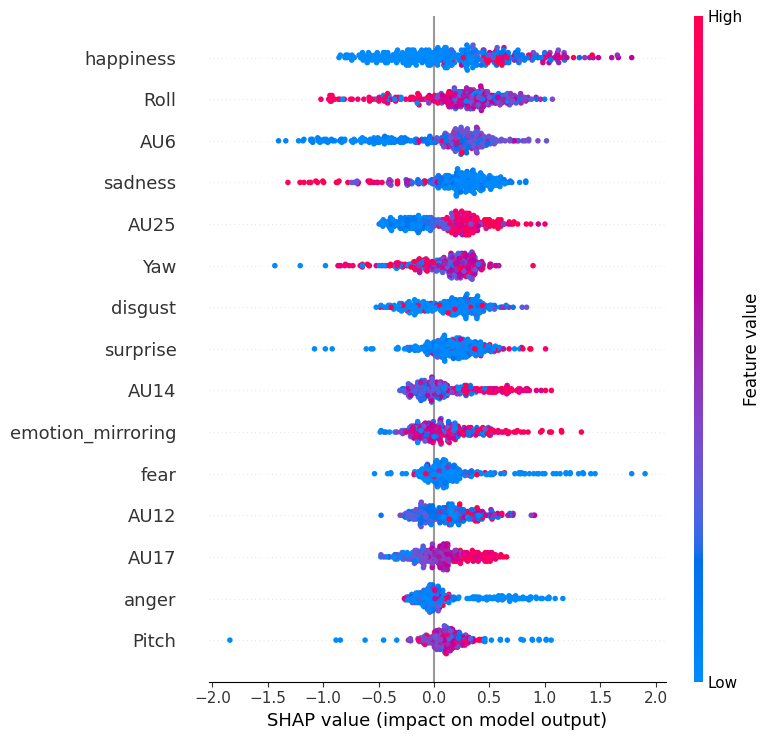

In [ ]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Define the number of samples you want
num_samples = 350

# Calculate Shap values
if smoteBool:
    print('smote')
    sample = X_train_smote.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample)
else:
    sample = X_train_filled.sample(n=num_samples, random_state=42, replace=True)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, max_display=15)


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

X_train_smote, y_train_smote = smote.fit_resample(X_train_filled, y_train)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_smote, X_test_filled, y_train_smote, y_test)

# Prints the model performance
print(models)

100%|██████████| 29/29 [00:23<00:00,  1.21it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
GaussianNB                         0.61               0.72     0.72      0.66   
NearestCentroid                    0.65               0.72     0.72      0.69   
LinearSVC                          0.64               0.70     0.70      0.69   
BernoulliNB                        0.64               0.70     0.70      0.69   
LogisticRegression                 0.64               0.70     0.70      0.69   
RidgeClassifierCV                  0.64               0.70     0.70      0.69   
RidgeClassifier                    0.64               0.70     0.70      0.69   
LinearDiscriminantAnalysis         0.64               0.70     0.70      0.69   
SVC                                0.80               0.70     0.70      0.81   
NuSVC                              0.80               0.69     0.69      0.81   
AdaBoostClassifier          

In [ ]:
# ###Create a background dataset (you can also use a subset of your train dataset)
# background_data = X_train_filled.iloc[90:93,:]

# ###Use KernelExplainer for SVM
# explainer = shap.KernelExplainer(svm_clf.predict_proba, background_data)

# ###Calculate shap_values for all of X
# shap_values = explainer.shap_values(X_test_filled)

# ###Plot the SHAP values
# shap.summary_plot(shap_values, X_test_filled)


Accuracy: 80.51%
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       207
           1       0.92      0.84      0.88      1096

    accuracy                           0.81      1303
   macro avg       0.67      0.73      0.69      1303
weighted avg       0.84      0.81      0.82      1303



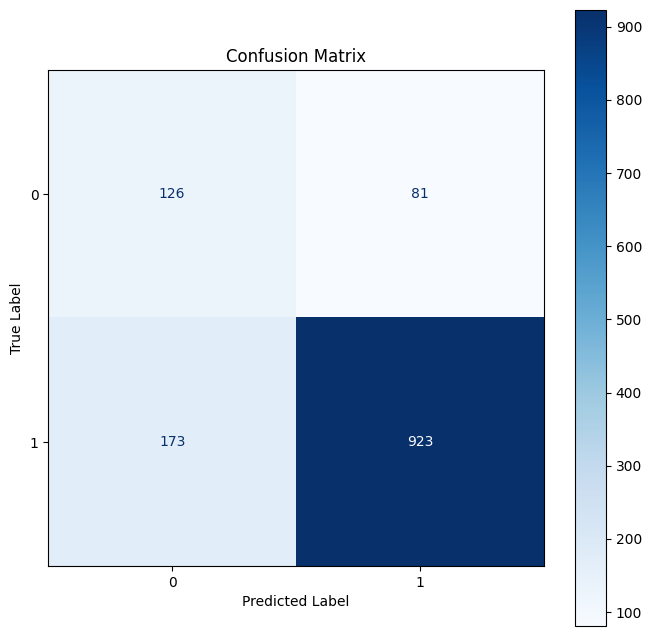

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred_svm))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
y_test.value_counts()

1    1096
0     207
Name: Label, dtype: int64

In [ ]:
y_test.value_counts()

1    1096
0     207
Name: Label, dtype: int64

In [ ]:
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 4],
#     'min_child_weight': [1, 3],
#     'gamma': [0.1, 0.01, 0.05],
#     'subsample': [0.4,0.6],
#     'colsample_bytree': [0.3, 0.8],
# }

# # Create an XGBoost classifier with default parameters
# xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# # Define the scoring metric (F1-score)
# scoring = make_scorer(f1_score)

# grid_search = GridSearchCV(
#     estimator=xgb_classifier,
#     param_grid=param_grid,
#     scoring=scoring,
#     cv=2,  # You can use more folds if needed
#     verbose=2,
#     n_jobs=-1,
# )

# if smoteBool:
#     grid_search.fit(X_train_smote, y_train_smote)
# else:
#     grid_search.fit(X_train_filled, y_train)


# # Get the best parameters and the corresponding best F1-score
# best_params = grid_search.best_params_
# best_f1_score = grid_search.best_score_

# print("Best Parameters: ", best_params)
# print("Best F1-score: ", best_f1_score)

# # Train and evaluate the XGBoost model with the best parameters
# best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
# if smoteBool:
#     best_xgb_model.fit(X_train_smote, y_train_smote)
#     y_pred = best_xgb_model.predict(X_test_filled)
# else:
#     best_xgb_model.fit(X_train_filled, y_train)
#     y_pred = best_xgb_model.predict(X_test_filled)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# print(classification_report(y_test, y_pred))

In [ ]:
import numpy as np
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data



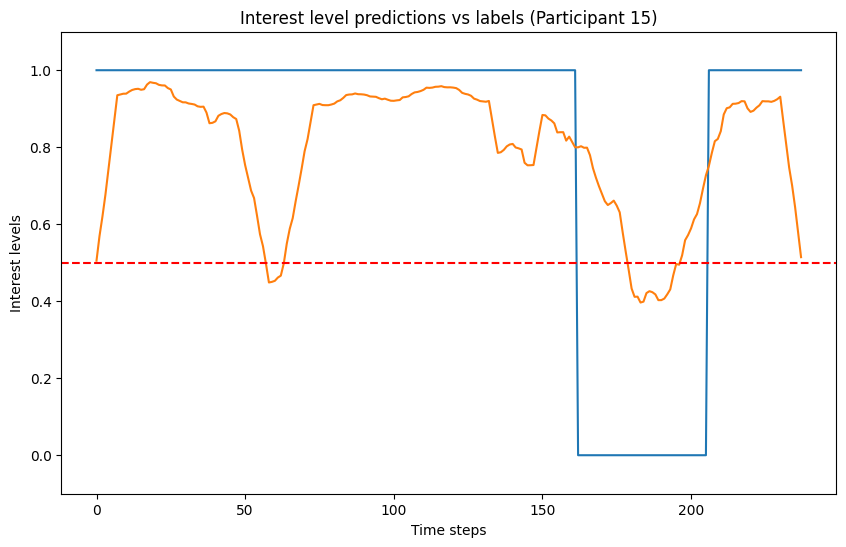

In [ ]:
temptest = "finaldata_250/15.csv"

chunked_df = preprocess_and_chunk(temptest, chunk_size)
otherDF = chunked_df.copy(deep=True)
otherDF = otherDF.drop(columns=['Label', 'Frame'])
otherDF = otherDF.fillna(otherDF.median())
y_pred_proba = svm_clf.predict_proba(otherDF)

temp = []
for x in y_pred_proba:
    temp.append(x[1])
temp = smooth_data(temp, 15)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(chunked_df.index, chunked_df['Label'])
plt.plot(range(len(temp)), temp, label='temp')
plt.axhline(0.5, color='r', linestyle='--', label='Threshold')


plt.xlabel('Time steps')
plt.ylabel('Interest levels')
plt.title('Interest level predictions vs labels (Participant 15)')
plt.ylim([-0.1, 1.1])  # this ensures that the y-axis is scaled appropriately for binary data
plt.show()